In [1]:
import numpy as np
import warnings;
warnings.simplefilter('ignore')
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import  seasonal_decompose
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("power_usage_2016_to_2020.csv",sep=',')
df

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday


In [3]:
df.rename(columns={'StartDate':'Date'},inplace=True)
df.drop(columns={'day_of_week','notes'},inplace=True)
df.rename(columns={'Value (kWh)':'Power_usage_kWh'},inplace=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop_duplicates(subset=['Date'])
df = df.fillna(0)

In [5]:
df.set_index('Date')

,Power_usage_kWh
Date,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932
...,...
2020-07-07 19:00:00,1.307
2020-07-07 20:00:00,2.872
2020-07-07 21:00:00,2.138


In [6]:
df_clean = df.groupby(pd.Grouper(key='Date', freq='M')).sum()

In [7]:
df_clean['Power_usage_kWh'].replace(to_replace=0, method='ffill',inplace=True)

In [8]:
result = adfuller(df_clean['Power_usage_kWh'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.4450470018415413
p-value: 0.009515788061875141
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944


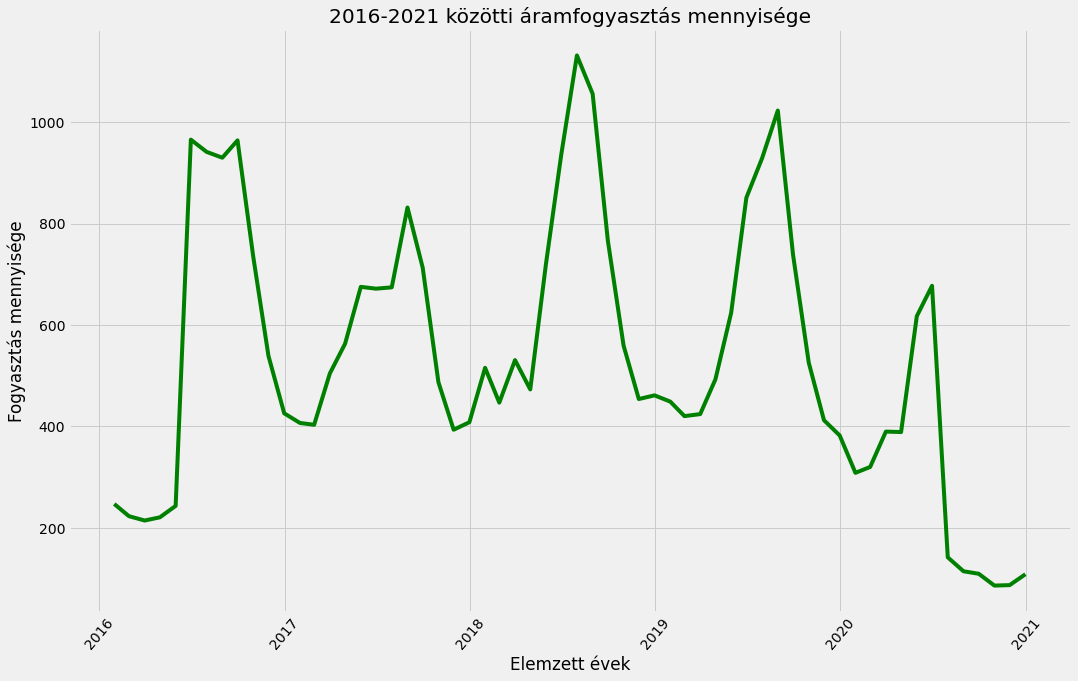

In [9]:
plt.figure(figsize=(16,10))
plt.plot(df_clean['Power_usage_kWh'],color="green")
plt.xlabel('Elemzett évek')
plt.xticks(rotation=50)
plt.ylabel('Fogyasztás mennyisége')
plt.title('2016-2021 közötti áramfogyasztás mennyisége')
plt.savefig('1.ábra.png')
plt.show()

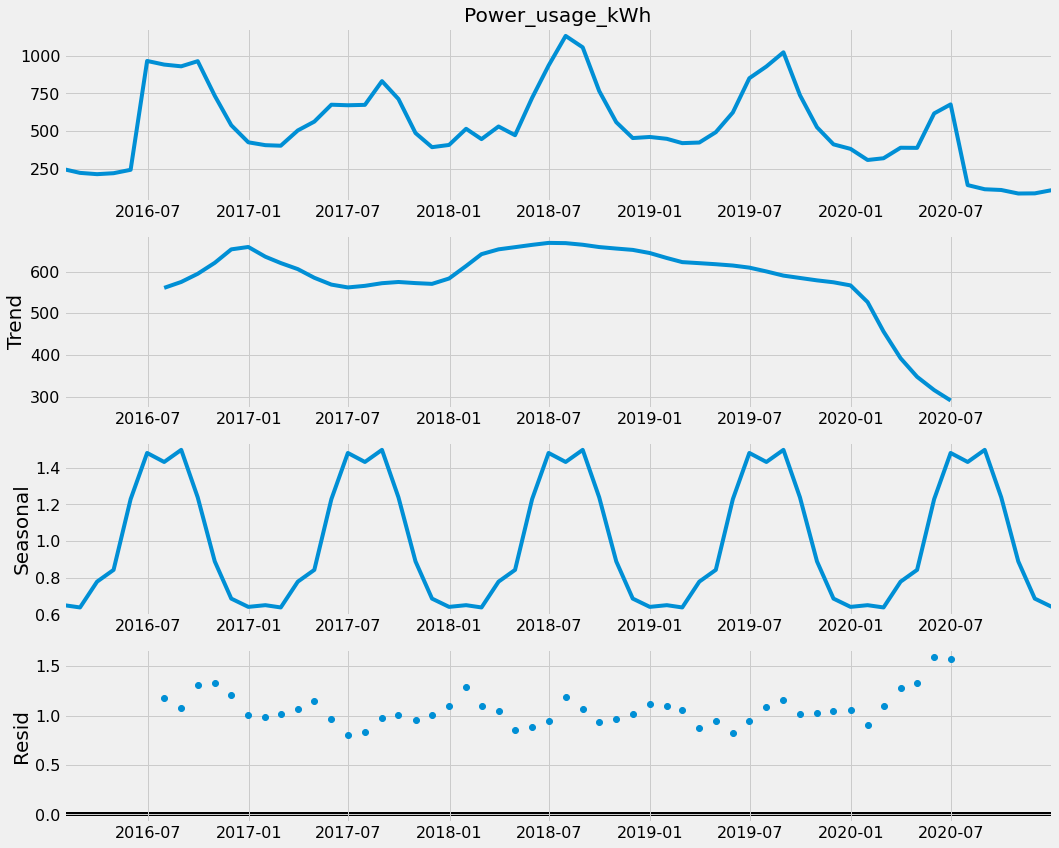

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
df_consumption = seasonal_decompose(df_clean["Power_usage_kWh"],model="multiplicative")
df_consumption.plot()
plt.savefig('2.ábra.png')

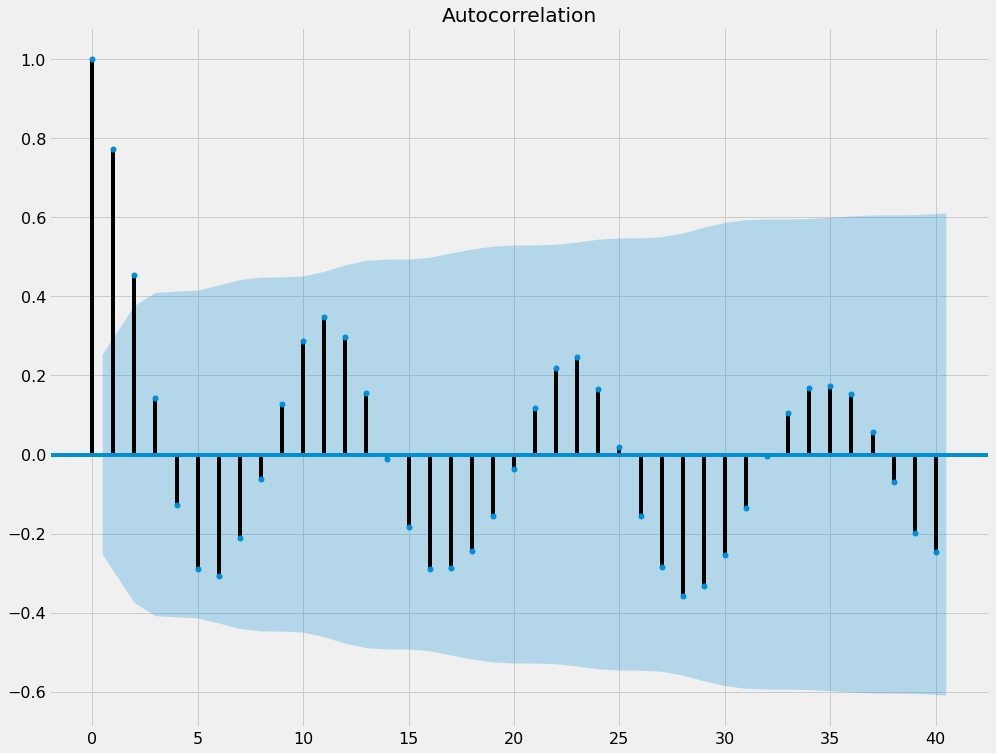

In [11]:
plot_acf(df_clean['Power_usage_kWh'].values.squeeze(),lags=40)
plt.savefig('acf.png')

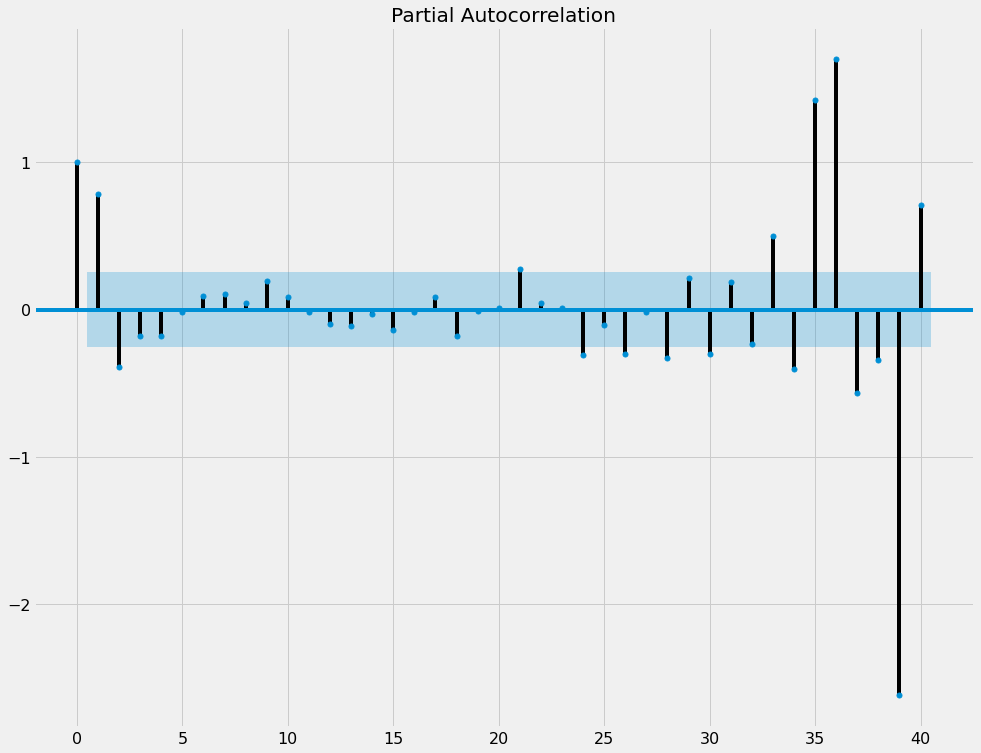

In [12]:
plot_pacf(df_clean['Power_usage_kWh'].values.squeeze(),lags=40)
plt.savefig('pacf.png')

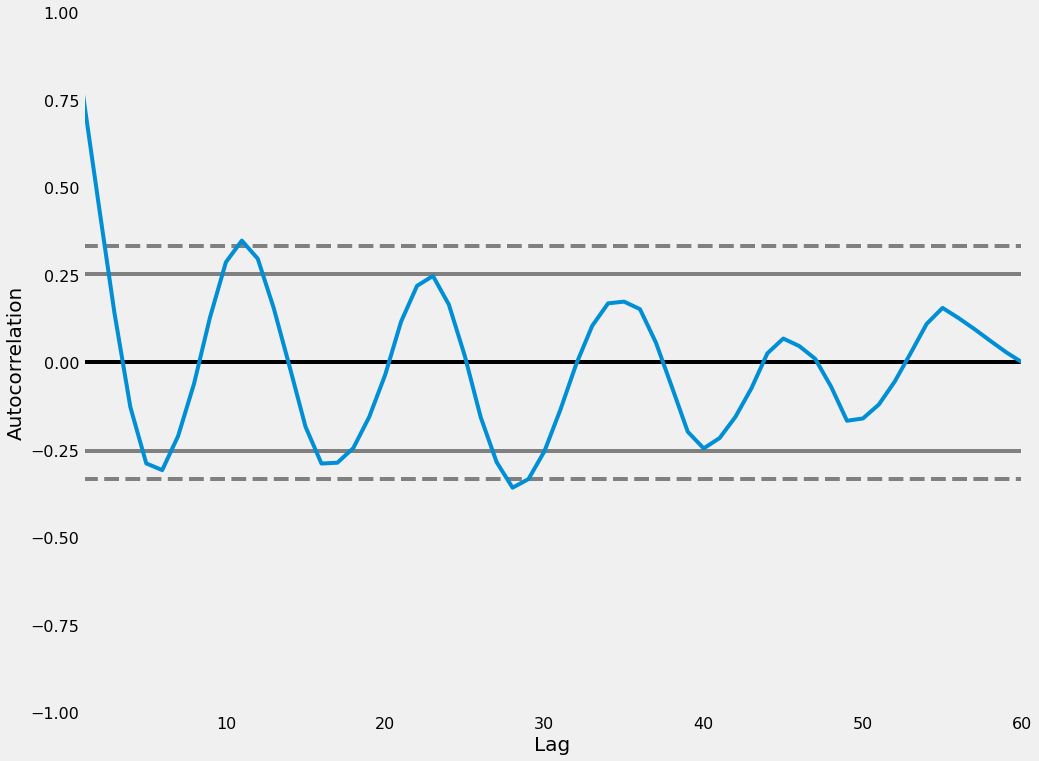

In [13]:
autocorrelation_plot(df_clean['Power_usage_kWh'])
plt.savefig('3.ábra.png')

C:\Users\martinturcsanyi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


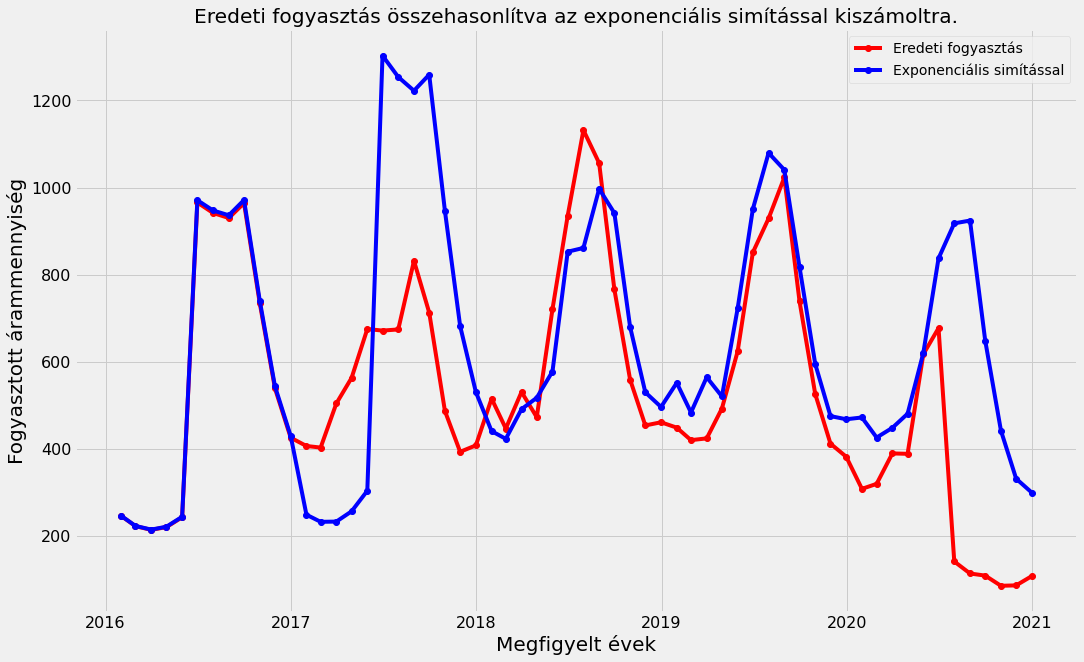

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df_clean['TESadd12'] = ExponentialSmoothing(df_clean['Power_usage_kWh'],trend='multiplicative',seasonal='multiplicative',seasonal_periods=12,freq='M').fit().fittedvalues

plt.figure(figsize=(16,10))
plt.plot(df_clean['Power_usage_kWh'],marker='o',color='red')
plt.plot(df_clean['TESadd12'],marker='o',color='blue')
plt.legend(['Eredeti fogyasztás', 'Exponenciális simítással'])
plt.xlabel('Megfigyelt évek')
plt.ylabel('Fogyasztott árammennyiség')
plt.title('Eredeti fogyasztás összehasonlítva az exponenciális simítással kiszámoltra.')
plt.savefig('4.ábra.png')
plt.show()

In [15]:
df_clean['Power_usage_kWh'].mean()

534.2653952007499

In [16]:
mape = np.mean(np.abs(df_clean['TESadd12'] - df_clean['Power_usage_kWh'])/np.abs(df_clean['Power_usage_kWh']))
print("MAPE value: ",mape*100," %")
mse = mean_squared_error(df_clean['Power_usage_kWh'],df_clean['TESadd12'])
print("Power_usage mean",df_clean['Power_usage_kWh'].mean())
print("RMSE value:",rmse(df_clean['Power_usage_kWh'],df_clean['TESadd12']))
print("MAE value: ",mae(df_clean['Power_usage_kWh'], df_clean['TESadd12']))

MAPE value:  64.52586219898495  %
Power_usage mean 534.2653952007499
RMSE value: 257.1707475314513
MAE value:  166.33603371185072


In [17]:
df_clean.shape
train = df_clean['Power_usage_kWh'].iloc[:40]
test = df_clean['Power_usage_kWh'].iloc[40:]

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

auto_arima(df_clean['Power_usage_kWh'],seasonal=True,m=12).summary()
model_sarimax = SARIMAX(train,order=(2,0,0),freq='M',seasonal_order=(1,0,0,12))
result = model_sarimax.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    Power_usage_kWh   No. Observations:                   40
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -259.824
Date:                            Sun, 09 May 2021   AIC                            527.647
Time:                                    23:48:08   BIC                            534.403
Sample:                                01-31-2016   HQIC                           530.090
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1053      0.237      4.669      0.000       0.641       1.569
ar.L2         -0.1801      0.250     -0.720      0.472      -0.670       0.310
ar.S.L12       0.3375      0.141      2.389      0.017       0.061       0.614
sigma2      2.333e+04   3168.177      7.363      0.000    1.71e+04    2.95e+04
===================================================================================
Ljung-Box (Q):                       26.11   Jarque-Bera (JB):               111.52
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             1.97
Prob(H) (two-sided):                  0.10   Kurtosis:                        10.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

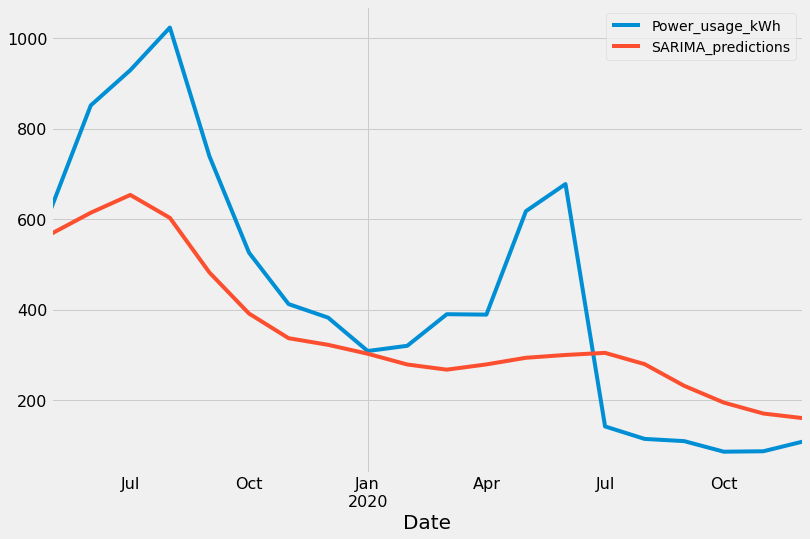

In [19]:
start = len(train)
end = len(train) + len(test)-1

predictions = result.predict(start,end,typ='levels').rename('SARIMA_predictions')

test.plot(legend=True,figsize=(12,8))
predictions.plot(legend=True)

In [20]:
error = rmse(test,predictions)
print(error)
print(test.mean())

196.52154310784724
441.74893062379977


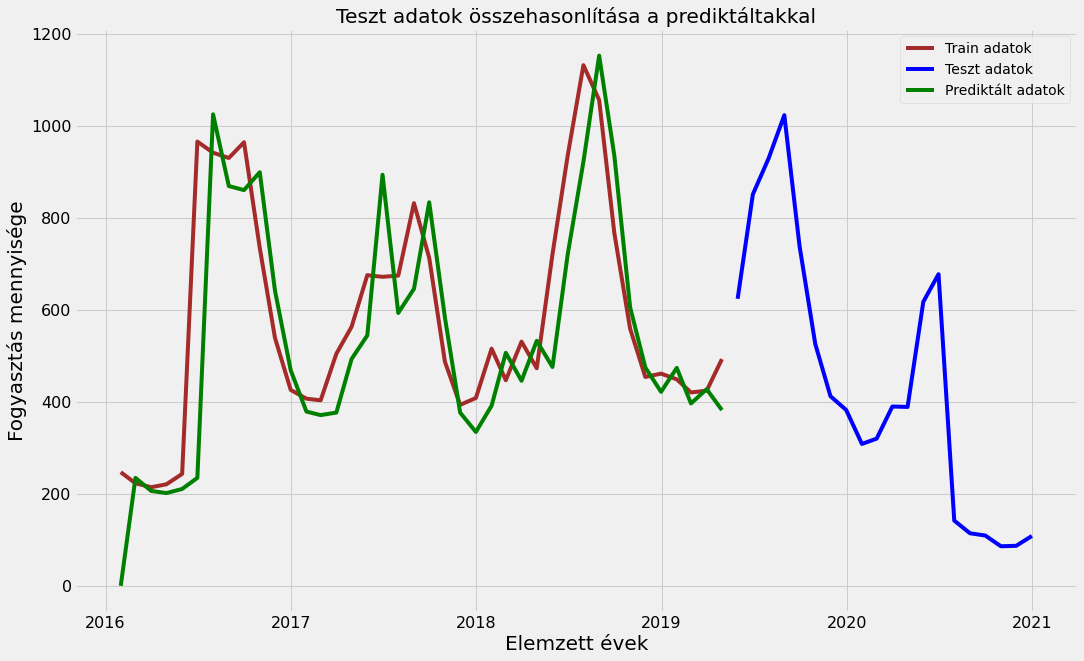

In [21]:
plt.figure(figsize=(16,10))
plt.plot(train,color='brown')
plt.plot(test,color='blue')
plt.plot(result.fittedvalues,color='green')
plt.legend(['Train adatok','Teszt adatok','Prediktált adatok'])
plt.xlabel('Elemzett évek')
plt.ylabel('Fogyasztás mennyisége')
plt.title('Teszt adatok összehasonlítása a prediktáltakkal')
plt.savefig('5.ábra.png')
plt.show()

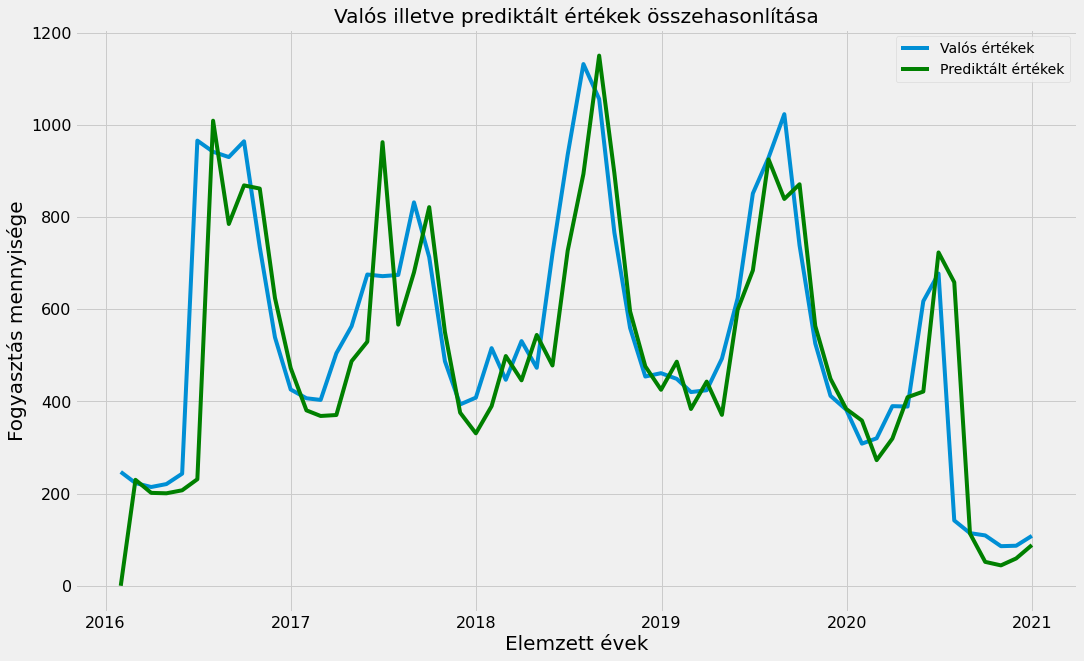

In [22]:
model = SARIMAX(df_clean['Power_usage_kWh'],order=(2,0,1),freq='M',seasonal_order=(1,0,0,12),m=12)
result = model.fit(disp=1)
plt.figure(figsize=(16,10))
plt.plot(df_clean['Power_usage_kWh'])
plt.plot(result.fittedvalues,color='green')
plt.legend(['Valós értékek','Prediktált értékek'])
plt.xlabel('Elemzett évek')
plt.ylabel('Fogyasztás mennyisége')
plt.title('Valós illetve prediktált értékek összehasonlítása')
plt.show()

In [23]:
df_clean

,Power_usage_kWh,TESadd12
Date,,
2016-01-31,247.007000,247.263933
2016-02-29,222.897000,223.348091
2016-03-31,214.316000,214.948432
2016-04-30,220.692000,221.535491
2016-05-31,243.253000,244.381091
2016-06-30,965.768000,970.981239
2016-07-31,941.657000,947.405115
2016-08-31,930.144000,936.429035
2016-09-30,964.346300,971.441351


In [24]:
start_index = '2020-12-31'
end_index = '2022-12-31'
a = result.predict(start=start_index, end=end_index)
a

2020-12-31     88.372185
2021-01-31     85.579891
2021-02-28     95.907691
2021-03-31    132.750952
2021-04-30    137.032712
2021-05-31    243.649125
2021-06-30    274.210360
2021-07-31     37.621002
2021-08-31     28.219989
2021-09-30     28.628155
2021-10-31     20.471131
2021-11-30     22.940633
2021-12-31     34.352466
2022-01-31     25.768509
2022-02-28     31.817685
2022-03-31     49.579596
2022-04-30     52.616477
2022-05-31    101.354318
2022-06-30    115.920253
2022-07-31     10.749915
2022-08-31      7.231519
2022-09-30      8.027466
2022-10-31      4.918171
2022-11-30      6.506032
2022-12-31     12.043820
Freq: M, dtype: float64

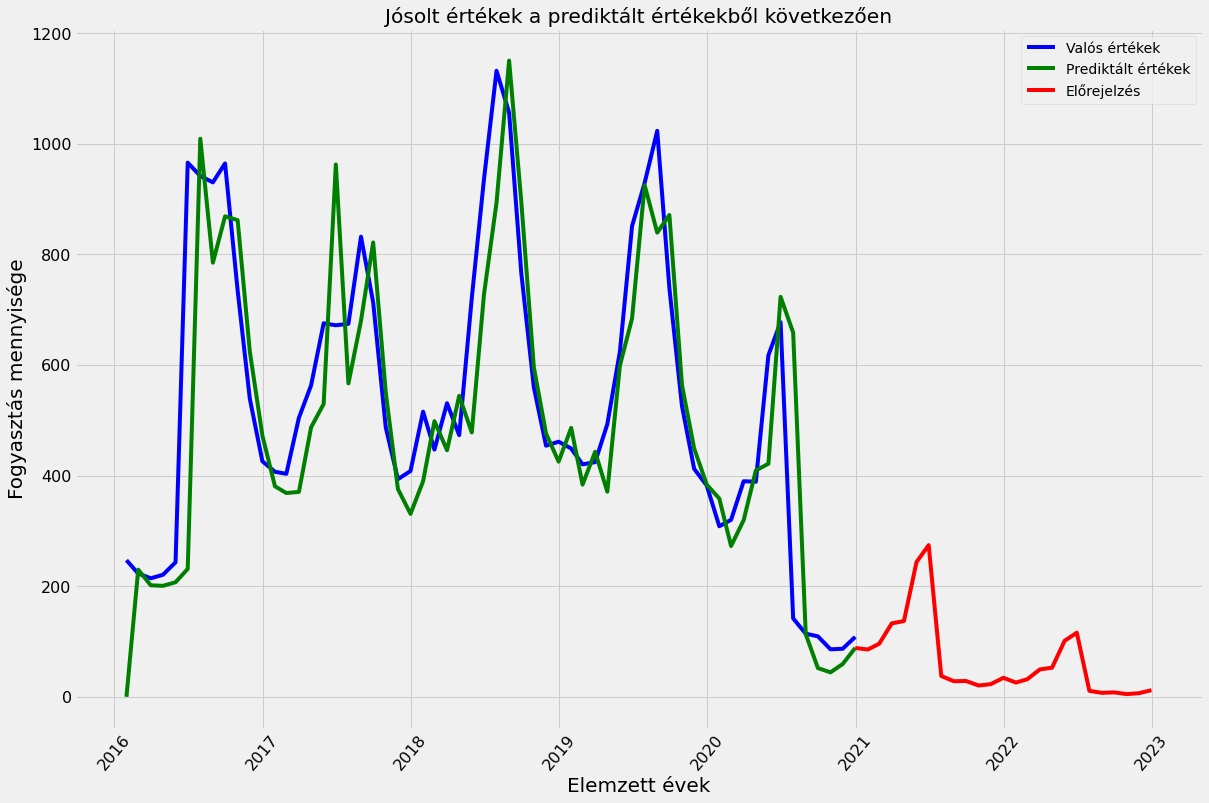

In [25]:
plt.figure(figsize=(18,12))
plt.plot(df_clean['Power_usage_kWh'],color='blue')
plt.plot(result.fittedvalues,color='green')
plt.plot(a, color='red')
plt.legend(['Valós értékek','Prediktált értékek','Előrejelzés'])
plt.xlabel('Elemzett évek')
plt.xticks(rotation=50)
plt.ylabel('Fogyasztás mennyisége')
plt.title('Jósolt értékek a prediktált értékekből következően')
plt.savefig('6.ábra.png')
plt.show()

In [26]:
arima_pred = result.predict(start = '2016-01-31', end = len(df_clean)-1, typ="levels").rename("ARIMA Predictions")

In [27]:
arima_pred
df_clean['ARIMA_Predictions'] = arima_pred

In [28]:
mape = np.mean(np.abs(df_clean['Power_usage_kWh'] - df_clean['ARIMA_Predictions'])/df_clean['Power_usage_kWh'])
print("MAPE value: ",mape*100," %")

MAPE value:  23.543605277808535  %


In [29]:
mse = mean_squared_error(df_clean['Power_usage_kWh'],df_clean['ARIMA_Predictions'])
print("Power_usage mean",df_clean['Power_usage_kWh'].mean())
print("RMSE value:",rmse(df_clean['Power_usage_kWh'],df_clean['ARIMA_Predictions']))
print("MAE value: ",mae(df_clean['Power_usage_kWh'], df_clean['ARIMA_Predictions']))

Power_usage mean 534.2653952007499
RMSE value: 157.80651818835258
MAE value:  101.61413328391059


In [30]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

smape(df_clean['Power_usage_kWh'], df_clean['ARIMA_Predictions'])

23.274807052449226

In [31]:
months = df_clean.index.month
monthly_sum=df_clean.groupby(months).sum()

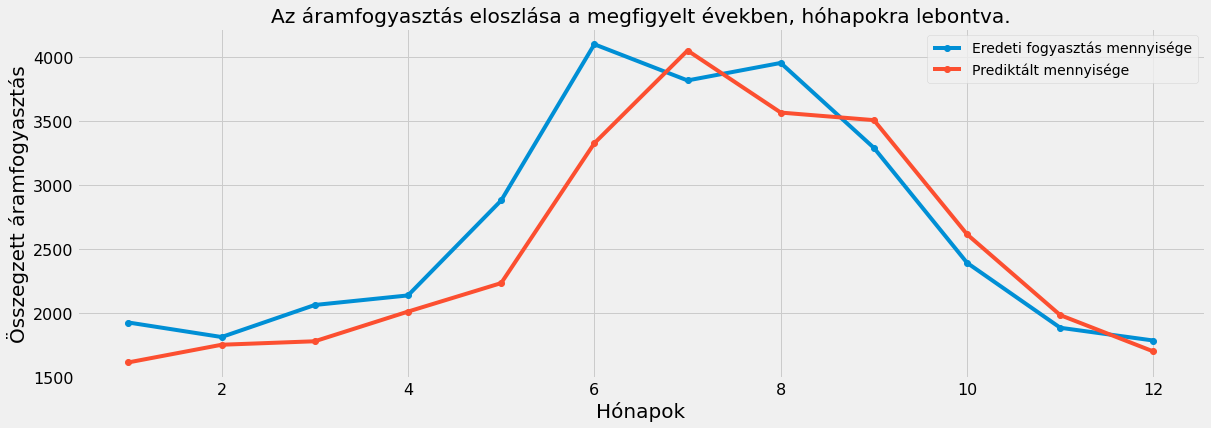

In [32]:
plt.figure(figsize=(18,6))
plt.plot(monthly_sum['Power_usage_kWh'],marker='o')
plt.plot(monthly_sum['ARIMA_Predictions'],marker='o')
plt.xlabel('Hónapok')
plt.ylabel('Összegzett áramfogyasztás')
plt.legend(['Eredeti fogyasztás mennyisége','Prediktált mennyisége'])
plt.title('Az áramfogyasztás eloszlása a megfigyelt években, hóhapokra lebontva.')
plt.show()

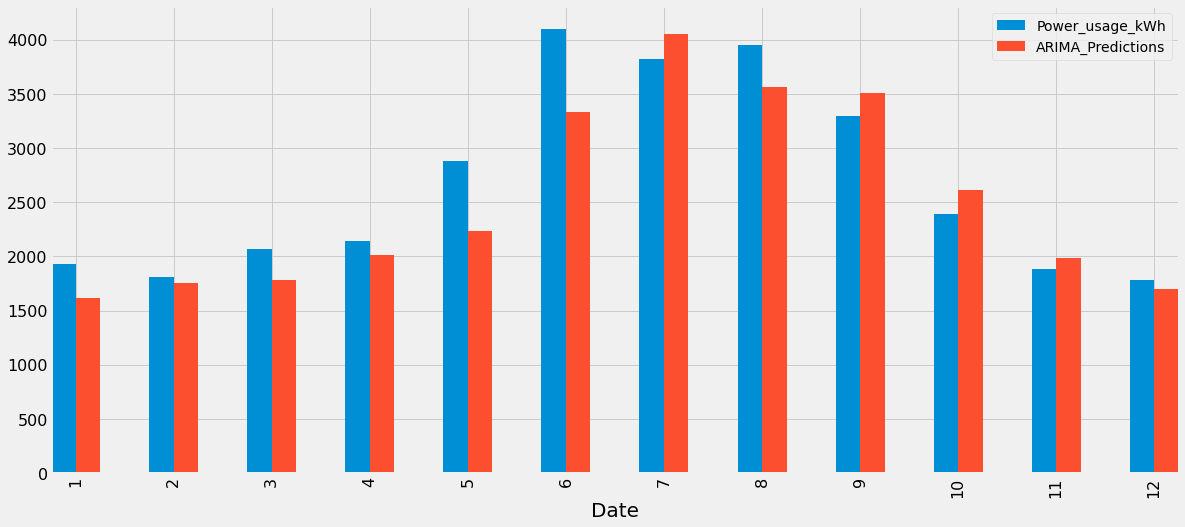

In [33]:
monthly_sum[['Power_usage_kWh','ARIMA_Predictions']].plot(figsize=(18,8),kind='bar').autoscale(axis='x',tight=True);

In [34]:
#pip install pystan==2.19.1.1
#pip install prophet -> nem működött, helyette:
# conda install -c conda-forge fbprophet
from fbprophet import Prophet

In [35]:
fd = pd.read_csv("power_usage_2016_to_2020.csv",sep=',')
fd.drop(['day_of_week','notes'],axis=1,inplace=True)
fd

,StartDate,Value (kWh)
0,2016-01-06 00:00:00,1.057
1,2016-01-06 01:00:00,1.171
2,2016-01-06 02:00:00,0.560
3,2016-01-06 03:00:00,0.828
4,2016-01-06 04:00:00,0.932
...,...,...
35947,2020-07-07 19:00:00,1.307
35948,2020-07-07 20:00:00,2.872
35949,2020-07-07 21:00:00,2.138
35950,2020-07-07 22:00:00,2.199


In [36]:
fd['StartDate'] = pd.to_datetime(fd['StartDate'])

In [37]:
fd.set_index('StartDate',inplace=True)

In [38]:
fd =fd.groupby(pd.Grouper(freq='M'))['Value (kWh)'].sum().reset_index()

In [39]:
fd.rename(columns={'StartDate':'ds','Value (kWh)':'y'},inplace=True)
fd = fd.drop_duplicates(subset=['ds'])
fd = fd.fillna(0)

In [40]:
m = Prophet(interval_width=0.95,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,seasonality_mode='multiplicative') #konfidencia intervallum
model = m.fit(fd)

In [41]:
future_predict = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future_predict)
df_prophet = forecast 
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-31,677.062528,-1.033611,688.764812,677.062528,677.062528,-0.475860,-0.475860,-0.475860,-0.475860,-0.475860,-0.475860,0.0,0.0,0.0,354.875416
1,2016-02-29,672.297306,38.313193,699.042565,672.297306,672.297306,-0.450068,-0.450068,-0.450068,-0.450068,-0.450068,-0.450068,0.0,0.0,0.0,369.717528
2,2016-03-31,667.203449,115.721596,807.323488,667.203449,667.203449,-0.312755,-0.312755,-0.312755,-0.312755,-0.312755,-0.312755,0.0,0.0,0.0,458.532070
3,2016-04-30,662.273909,170.245618,858.909669,662.273909,662.273909,-0.231923,-0.231923,-0.231923,-0.231923,-0.231923,-0.231923,0.0,0.0,0.0,508.677315
4,2016-05-31,657.180052,333.231719,1030.892843,657.180052,657.180052,0.018945,0.018945,0.018945,0.018945,0.018945,0.018945,0.0,0.0,0.0,669.630027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2022-08-31,278.305036,134.297031,815.025933,277.979077,278.620934,0.659661,0.659661,0.659661,0.659661,0.659661,0.659661,0.0,0.0,0.0,461.892016
80,2022-09-30,273.292989,-9.002584,688.153786,272.948785,273.636433,0.262771,0.262771,0.262771,0.262771,0.262771,0.262771,0.0,0.0,0.0,345.106373
81,2022-10-31,268.113873,-107.540734,564.520975,267.746064,268.479266,-0.083127,-0.083127,-0.083127,-0.083127,-0.083127,-0.083127,0.0,0.0,0.0,245.826503
82,2022-11-30,263.101826,-142.832816,556.838327,262.714331,263.491509,-0.235210,-0.235210,-0.235210,-0.235210,-0.235210,-0.235210,0.0,0.0,0.0,201.217545


In [42]:
df_prophet.drop(columns=['trend','yhat_lower','yhat_upper','trend_lower','trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'],axis=1,inplace=True)

In [43]:
df_prophet

,ds,yhat
0,2016-01-31,354.875416
1,2016-02-29,369.717528
2,2016-03-31,458.532070
3,2016-04-30,508.677315
4,2016-05-31,669.630027
...,...,...
79,2022-08-31,461.892016
80,2022-09-30,345.106373
81,2022-10-31,245.826503
82,2022-11-30,201.217545


In [44]:
df_prophet.rename(columns={'ds':'Date','y':'Power_usage_kWh'},inplace=True)

In [45]:
df_prophet.set_index('Date',inplace=True)

In [46]:
df_prophet

,yhat
Date,
2016-01-31,354.875416
2016-02-29,369.717528
2016-03-31,458.532070
2016-04-30,508.677315
2016-05-31,669.630027
...,...
2022-08-31,461.892016
2022-09-30,345.106373
2022-10-31,245.826503


In [47]:
df_clean = pd.merge(df_clean,df_prophet,on='Date')
df_clean.rename(columns={'yhat':'Prophet_Predictions'},inplace=True)

In [48]:
df_clean

,Power_usage_kWh,TESadd12,ARIMA_Predictions,Prophet_Predictions
Date,,,,
2016-01-31,247.007000,247.263933,0.000000,354.875416
2016-02-29,222.897000,223.348091,229.889633,369.717528
2016-03-31,214.316000,214.948432,201.581156,458.532070
2016-04-30,220.692000,221.535491,200.662924,508.677315
2016-05-31,243.253000,244.381091,207.176937,669.630027
2016-06-30,965.768000,970.981239,231.239200,1105.030890
2016-07-31,941.657000,947.405115,1009.024738,892.562312
2016-08-31,930.144000,936.429035,784.927953,895.562335
2016-09-30,964.346300,971.441351,868.707713,875.922403


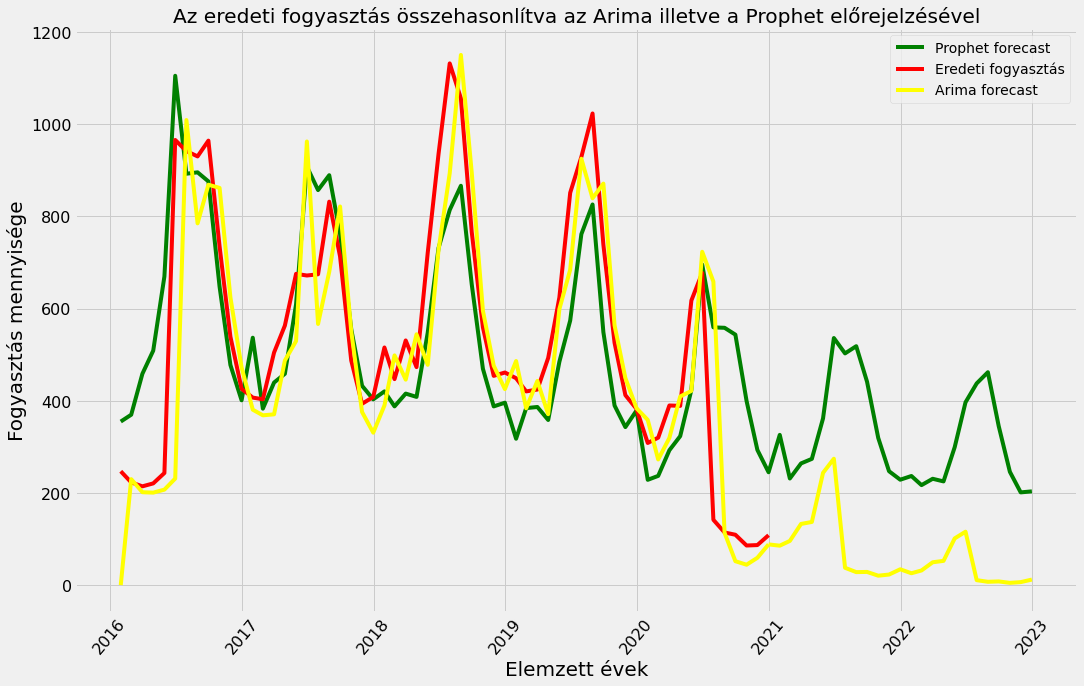

In [49]:
plt.figure(figsize=(16,10))
plt.plot(forecast['yhat'],color='green')
plt.plot(df_clean['Power_usage_kWh'],color='red')
plt.plot(df_clean['ARIMA_Predictions'],color='yellow')
plt.plot(a,color='yellow')
plt.legend(['Prophet forecast','Eredeti fogyasztás','Arima forecast'])
plt.xlabel('Elemzett évek')
plt.xticks(rotation=50)
plt.ylabel('Fogyasztás mennyisége')
plt.title('Az eredeti fogyasztás összehasonlítva az Arima illetve a Prophet előrejelzésével')
plt.savefig('7.ábra.png')
plt.show()

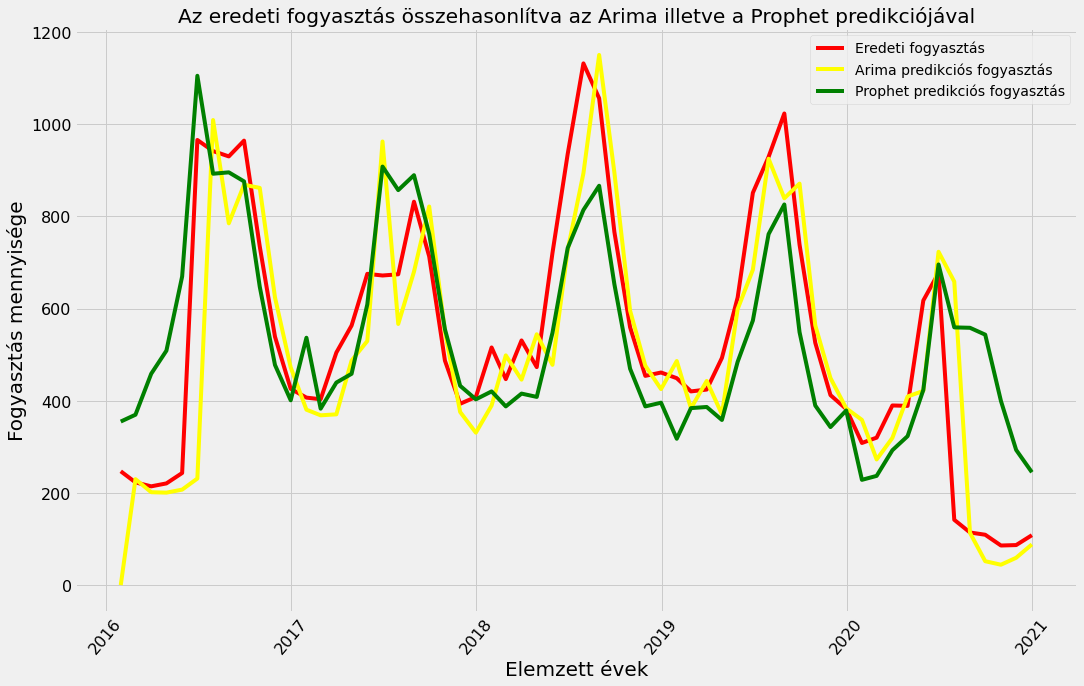

In [50]:
plt.figure(figsize=(16,10))
plt.plot(df_clean['Power_usage_kWh'],color='red')
plt.plot(df_clean['ARIMA_Predictions'],color='yellow')
plt.plot(df_clean['Prophet_Predictions'],color='green')
plt.legend(['Eredeti fogyasztás','Arima predikciós fogyasztás','Prophet predikciós fogyasztás'])
plt.xlabel('Elemzett évek')
plt.xticks(rotation=50)
plt.ylabel('Fogyasztás mennyisége')
plt.title('Az eredeti fogyasztás összehasonlítva az Arima illetve a Prophet predikciójával')
plt.show()

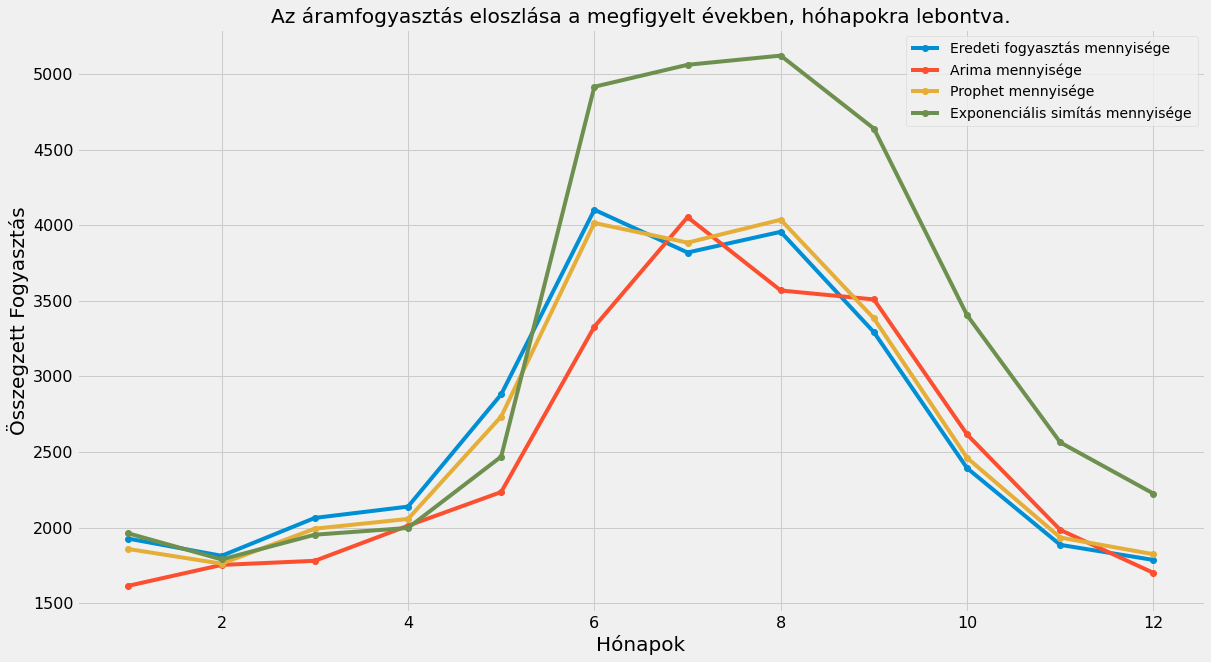

In [52]:
months = df_clean.index.month
monthly_sum=df_clean.groupby(months).sum()
plt.figure(figsize=(18,10))
plt.plot(monthly_sum['Power_usage_kWh'],marker='o')
plt.plot(monthly_sum['ARIMA_Predictions'],marker='o')
plt.plot(monthly_sum['Prophet_Predictions'],marker='o')
plt.plot(monthly_sum['TESadd12'],marker='o')
plt.xlabel('Hónapok')
plt.ylabel('Összegzett Fogyasztás')
plt.legend(['Eredeti fogyasztás mennyisége','Arima mennyisége','Prophet mennyisége','Exponenciális simítás mennyisége'])
plt.title('Az áramfogyasztás eloszlása a megfigyelt években, hóhapokra lebontva.')
plt.savefig('8.ábra.png')
plt.show()

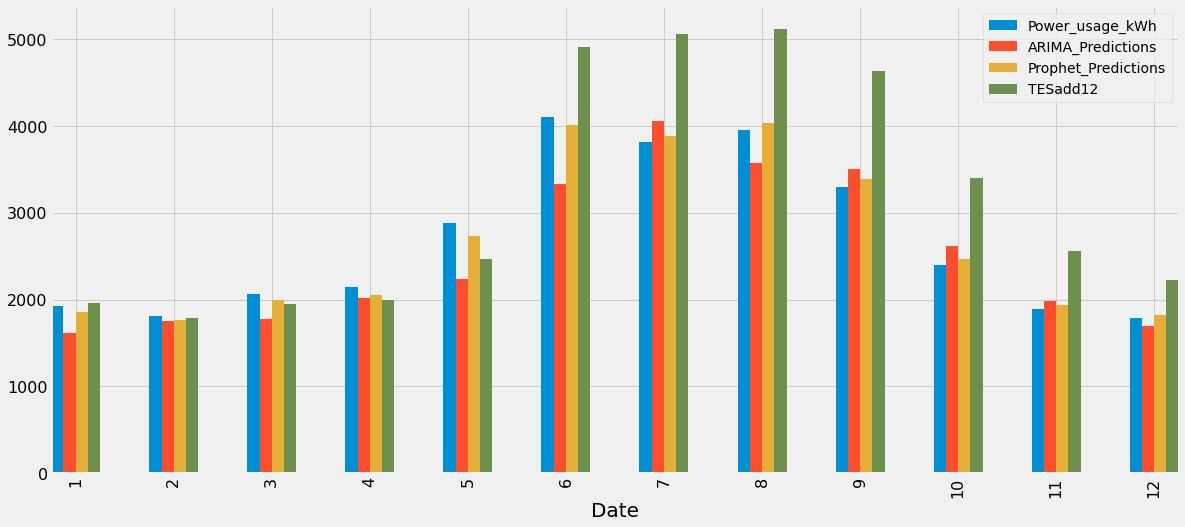

In [53]:
monthly_sum[['Power_usage_kWh','ARIMA_Predictions','Prophet_Predictions','TESadd12']].plot(figsize=(18,8),kind='bar').autoscale(axis='x',tight=True);
plt.savefig('9.ábra.png')

In [54]:
mse = mean_squared_error(df_clean['Power_usage_kWh'],df_clean['Prophet_Predictions'])
print("Power_usage mean",df_clean['Power_usage_kWh'].mean())
print("RMSE value:",rmse(df_clean['Power_usage_kWh'],df_clean['Prophet_Predictions']))
mape = np.mean(np.abs(df_clean['Prophet_Predictions'] - df_clean['Power_usage_kWh'])/np.abs(df_clean['Power_usage_kWh']))
print("MAPE value: ",mape*100,"%")
print("MAE value: ",mae(df_clean['Power_usage_kWh'], df_clean['Prophet_Predictions']))
print("Symmetric MAPE",smape(df_clean['Power_usage_kWh'], df_clean['Prophet_Predictions']))

Power_usage mean 534.2653952007499
RMSE value: 175.69831319546174
MAPE value:  52.688414249161006 %
MAE value:  138.11440923576274
Symmetric MAPE 31.955885821239526


In [55]:
df_forecasted = []

In [56]:
df_forecasted = a.to_frame()

In [57]:
df_forecasted.rename(columns={0:'ARIMA'},inplace=True)

In [58]:
forecast['yhat'][-24:]

Date
2021-01-31    326.006369
2021-02-28    231.334320
2021-03-31    264.061056
2021-04-30    273.911577
2021-05-31    361.715007
2021-06-30    536.080214
2021-07-31    502.765870
2021-08-31    518.389456
2021-09-30    441.295637
2021-10-31    319.380472
2021-11-30    247.121505
2021-12-31    228.697386
2022-01-31    236.756804
2022-02-28    216.969907
2022-03-31    230.724656
2022-04-30    225.042945
2022-05-31    299.254020
2022-06-30    396.629779
2022-07-31    437.670474
2022-08-31    461.892016
2022-09-30    345.106373
2022-10-31    245.826503
2022-11-30    201.217545
2022-12-31    203.420519
Name: yhat, dtype: float64

In [59]:
df_forecasted['Prophet'] = forecast['yhat'][-24:]

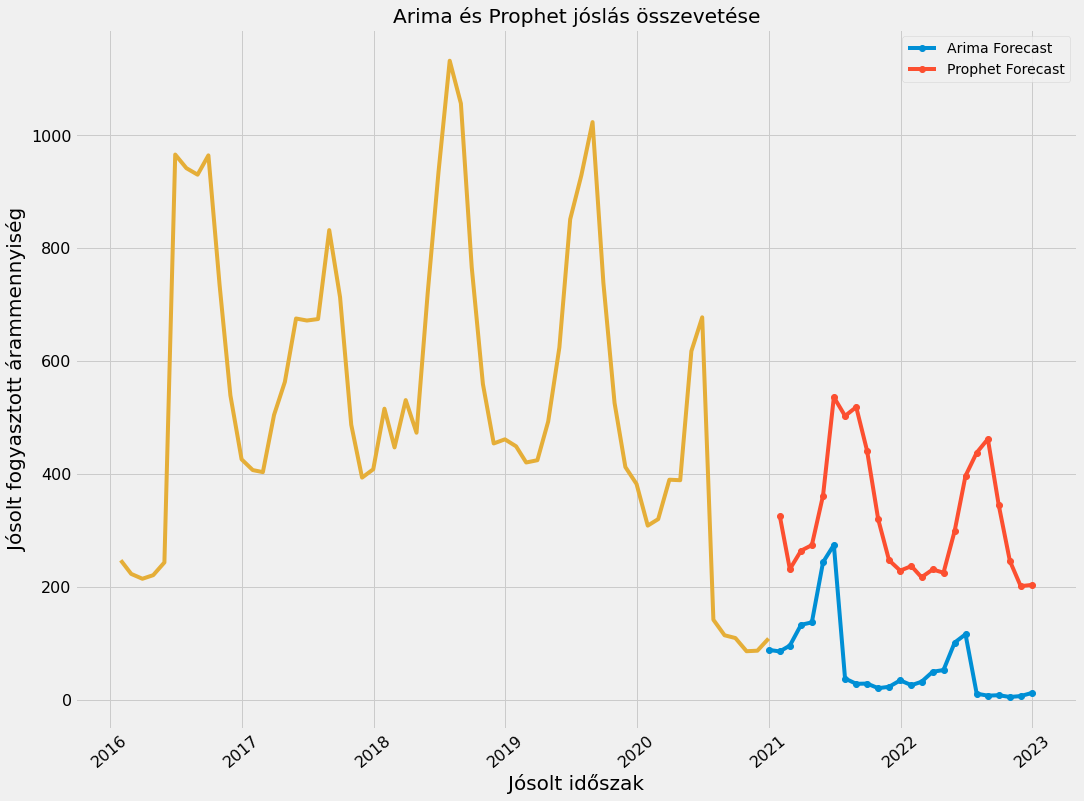

In [60]:
plt.figure(figsize=(16,12))
plt.plot(df_forecasted['ARIMA'],marker='o')
plt.plot(df_forecasted['Prophet'],marker='o')
plt.plot(df_clean['Power_usage_kWh'])
plt.title('Arima és Prophet jóslás összevetése')
plt.xlabel('Jósolt időszak')
plt.xticks(rotation=40)
plt.ylabel('Jósolt fogyasztott árammennyiség')
plt.legend(['Arima Forecast','Prophet Forecast'])
plt.savefig('10.ábra.png')
plt.show()

In [61]:
c = df_forecasted['ARIMA'].sum()
d = df_forecasted['Prophet'].sum()
e = abs(c-d)
e

6095.000356568424